In [4]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(False)

np.float64(0.35650769640692814)

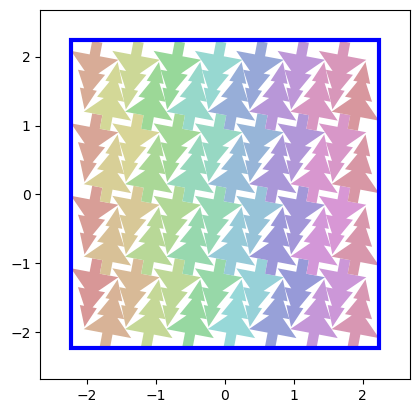

In [5]:
sol = kgs.dill_load(kgs.code_dir + '/../res/opt_practice.pickle')
sol.__class__ = kgs.SolutionCollectionSquare
assert isinstance(sol, kgs.SolutionCollection)
pack_vis_sol.pack_vis_sol(sol)
sol.h[0,0].get()**2/sol.N_trees

In [6]:
# import pack_ga
# cost = pack_ga.GA().fine_relaxers[0].cost
# relaxer = pack_ga.GA().fine_relaxers[0]
# relaxer.plot_interval = 1.
# sol_opt = copy.deepcopy(sol)
# sol_opt = relaxer.run_simulation(sol_opt)
# sol_opt.h[0,0].get()**2/sol_opt.N_trees, cost.compute_cost_allocate(sol_opt)[0]


0.35650769640692814 [1.91282642] [1.71318211]
Optimization terminated successfully.
         Current function value: 0.226370
         Iterations: 167
         Function evaluations: 176
         Gradient evaluations: 176
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.2263701965335987
        x: [-2.151e+00 -1.575e+00 ... -8.474e-03  7.851e-03]
      nit: 167
      jac: [ 3.666e-03 -2.161e-03 ...  3.916e-03  4.158e-04]
 hess_inv: [[ 1.801e-01 -1.538e-02 ...  6.465e-02  8.195e-03]
            [-1.538e-02  3.424e-01 ...  1.312e-02 -2.879e-03]
            ...
            [ 6.465e-02  1.312e-02 ...  9.152e-02  6.041e-03]
            [ 8.195e-03 -2.879e-03 ...  6.041e-03  7.155e-02]]
     nfev: 176
     njev: 176
176
0.4020933358582114 [0.2263702] [0.00029948]
Optimization terminated successfully.
         Current function value: 0.227085
         Iterations: 100
         Function evaluations: 105
         Gradient evaluations: 105
  message: Optim

<Axes: >

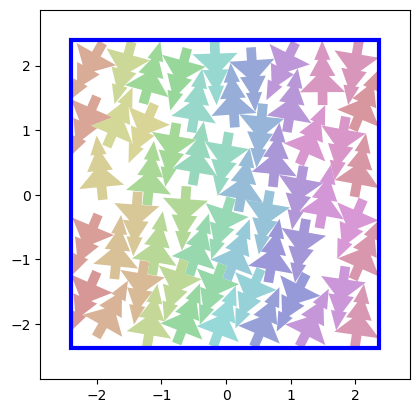

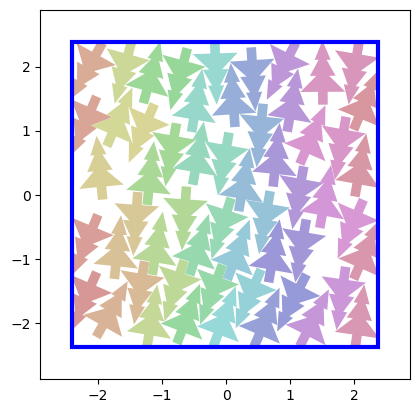

In [7]:
import pack_ga
sol_tmp = copy.deepcopy(sol)
sol_tmp.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.1,sol_tmp.xyt.shape))
cost = pack_ga.GA().fine_relaxers[0].cost
cost_v = copy.deepcopy(cost)
cost_v.costs.pop(0)
for _ in range(4):
    print(sol_tmp.h[0,0].get()**2/sol_tmp.N_trees, cost.compute_cost_allocate(sol_tmp)[0], cost_v.compute_cost_allocate(sol_tmp)[0])
    cost.costs[1].scaling *= 4
    cost.costs[2].scaling *= 4
    tmp_grad = cp.zeros_like(sol_tmp.xyt)
    tmp_grad_h = cp.zeros_like(sol_tmp.h)
    tmp_cost= cp.zeros(1, dtype=kgs.dtype_cp)
    counter = 0
    sol_int= copy.deepcopy(sol_tmp)
    def f(x):
        global counter
        counter += 1
        x=cp.array(x)
        global sol_tmp
        NN = sol_tmp.N_trees*3
        sol_int.xyt[...] = x[:NN].reshape(sol_tmp.xyt.shape)
        sol_int.h[...] = x[NN:].reshape(sol_tmp.h.shape)
        cost.compute_cost(sol_int, tmp_cost, tmp_grad, tmp_grad_h)
        res = cp.zeros_like(x)
        res[:NN] = tmp_grad.reshape(-1)
        res[NN:] = tmp_grad_h.reshape(-1)
        return tmp_cost[0].get(), res.get()
    x0 = np.concatenate((sol_tmp.xyt.reshape(-1).get(), sol_tmp.h.reshape(-1).get()))
    import scipy.optimize
    res = scipy.optimize.minimize(f, x0, tol=1e-30, method='BFGS', jac=True,
                                options={'maxiter': 5000, 'gtol':1e-2, 'xrtol': 0, 'disp': True})
    print(res)
    print(counter)
    sol_opt = copy.deepcopy(sol)
    NN = sol_opt.N_trees*3
    sol_opt.xyt[...] = cp.array(res.x[:NN].reshape(sol.xyt.shape))
    sol_opt.h[...] = cp.array(res.x[NN:].reshape(sol.h.shape))    
    sol_tmp = copy.deepcopy(sol_opt)
pack_vis_sol.pack_vis_sol(sol_opt)
sol_tmp = copy.deepcopy(sol_opt)
sol_tmp.xyt[:,:,:2]*=1.01
pack_vis_sol.pack_vis_sol(sol_tmp)
#print(sol_tmp.h[0,0].get()**2/sol_tmp.N_trees, cost.compute_cost_allocate(sol_tmp)[0], cost.costs[2].compute_cost_allocate(sol_tmp)[0])
#import pack_io
#xx=pack_io.solution_list_to_dataframe([sol_opt])


In [8]:
%load_ext pyinstrument

In [9]:
#%%pyinstrument
import tensorflow as tf
import tensorflow_probability as tfp
import cupy as cp

sol_to_solve = copy.deepcopy(sol)
sol_to_solve.select_ids([1]*1)

sol_tmp = copy.deepcopy(sol_to_solve)
sol_tmp.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.01,sol_tmp.xyt.shape))

x0 = cp.concatenate((sol_tmp.xyt.reshape(sol_tmp.N_solutions,-1), sol_tmp.h.reshape(sol_tmp.N_solutions,-1)),axis=1).get()

tmp_grad = cp.zeros_like(sol_tmp.xyt)
tmp_grad_h = cp.zeros_like(sol_tmp.h)
tmp_cost= cp.zeros(sol_tmp.N_solutions, dtype=kgs.dtype_cp)

counter = 0
counter_n = 0

cost = pack_ga.GA().fine_relaxers[0].cost

def f_batched(x):
    global counter, counter_n
    counter += 1
    counter_n += x.shape[0]
    x=cp.array(x)
    global sol_tmp
    NN = sol_tmp.N_trees*3
    sol_tmp.xyt[...] = x[:,:NN].reshape(sol_tmp.xyt.shape)
    sol_tmp.h[...] = x[:,NN:].reshape(sol_tmp.h.shape)
    cost.compute_cost(sol_tmp, tmp_cost, tmp_grad, tmp_grad_h)
    res = cp.zeros_like(x)
    res[:,:NN] = tmp_grad.reshape(sol_tmp.N_solutions,-1)
    res[:,NN:] = tmp_grad_h.reshape(sol_tmp.N_solutions,-1)
    return tmp_cost.get(), res.get()

def make_tfp_bfgs_from_cupy(f_cupy, M: int, N: int, dtype=tf.float64):
    """
    f_cupy: callable(x_cp[M,N]) -> (cost_cp[M], grad_cp[M,N])
            both are CuPy arrays.
    Returns: value_and_gradients_function(position_tf) suitable for tfp.optimizer.bfgs_minimize.
    """

    def value_and_grad_tf(position_tf):
        position_tf = tf.cast(position_tf, dtype)

        def _py_eval(x_np):
            # x_np is a NumPy array on host because tf.py_function passes host arrays.
            # We move it to CuPy, run f, then bring results back to NumPy for TF.
            x_cp = cp.asarray(x_np)#.reshape(M,N)
            cost_cp, grad_cp = f_cupy(x_cp)

            # Ensure correct dtypes
            cost_cp = cost_cp.astype(cp.float64 if dtype == tf.float64 else cp.float32)
            grad_cp = grad_cp.astype(cp.float64 if dtype == tf.float64 else cp.float32)

            # Back to NumPy (this is a device->host transfer)
            return (cp.asnumpy(cost_cp), cp.asnumpy(grad_cp))

        cost_tf, grad_tf = tf.py_function(
            func=_py_eval,
            inp=[position_tf],
            Tout=[dtype, dtype],
        )

        # Tell TF the shapes (py_function erases shape info)
        #cost_tf.set_shape([M])
        #grad_tf.set_shape([M, N])

        return cost_tf, grad_tf

    return value_and_grad_tf

kgs.debugging_mode = 2
value_and_grad = make_tfp_bfgs_from_cupy(f_batched, M=sol_tmp.N_solutions, N=x0.shape[1], dtype=kgs.dtype_np)

x0_tf = tf.convert_to_tensor(x0, dtype=kgs.dtype_np)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)

results = tfp.optimizer.bfgs_minimize(
    value_and_gradients_function=value_and_grad,
    initial_position=x0_tf,
    tolerance=1e-2,
    max_iterations=5000,
    #max_line_search_iterations=200
    #parallel_iterations=1,  # keep Python callback manageable
)

x_result = cp.array(results.position.numpy())
sol_opt = copy.deepcopy(sol_to_solve)
NN = sol_opt.N_trees*3
sol_opt.xyt[...] = x_result[:,:NN].reshape(sol_opt.xyt.shape)
sol_opt.h[...] = x_result[:,NN:].reshape(sol_opt.h.shape)    
counter, cost.compute_cost_allocate(sol_opt)[0]


2025-12-14 21:07:16.263761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-14 21:07:16.386376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-14 21:07:17.723115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765742839.190340   72768 gpu_device.cc:2020] Created device /job:localhost/rep

(64, array([0.1950184]))

In [10]:
%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


/tmp/ipykernel_72768/3856418267.py:18: OptimizeWarning: Unknown solver options: norm, xrtol
  res = scipy.optimize.minimize(f, x0, method='L-BFGS-B', jac=True,
/tmp/ipykernel_72768/3856418267.py:18: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = scipy.optimize.minimize(f, x0, method='L-BFGS-B', jac=True,


(144, 0.19435235333570558)

_     ._   __/__   _ _  _  _ _/_   Recorded: 21:07:22  Samples:  383
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.714     CPU time: 6.641
/   _/                      v5.1.1

Cell [12]

0.713 <module>  /tmp/ipykernel_72768/3856418267.py:1
`- 0.709 minimize  scipy/optimize/_minimize.py:54
      [6 frames hidden]  scipy, <built-in>
         0.691 MemoizeJac._compute_if_needed  scipy/optimize/_optimize.py:71
         `- 0.691 f  /tmp/ipykernel_72768/3856418267.py:2
            `- 0.691 f_batched  /tmp/ipykernel_72768/2517825144.py:23
               |- 0.452 SolutionCollectionSquare.N_solutions  kaggle_support.py:355
               |  `- 0.452 to_cpu  kaggle_support.py:180
               |     `- 0.448 ndarray.get  <built-in>
               |- 0.206 CostCompound.compute_cost  pack_cost.py:48
               |  |- 0.195 CostCompound._compute_cost  pack_cost.py:86
               |  |  |- 0.112 AreaCost.compute_cost  pack_cost.py:48
               |  |  |  |- 0.042 AreaCost._compute_cost  pack_cost.py:876
               |  |  |  |  `- 0.038 SolutionCollectionSquare.compute_cost  kaggle_support.py:441
               |  |  |  |- 0.037 [self]  pack_cost.py
               |  |  |  |- 0.017 BoundaryDistanceCost._compute_cost  pack_cost.py:1014
               |  |  |  |  `- 0.017 boundary_distance_multi_ensemble  pack_cuda.py:1403
               |  |  |  `- 0.015 CollisionCostSeparation._compute_cost  pack_cost.py:316
               |  |  |     `- 0.015 CollisionCostSeparation._compute_cost_internal  pack_cost.py:788
               |  |  |        `- 0.011 overlap_multi_ensemble  pack_cuda.py:1166
               |  |  |- 0.061 [self]  pack_cost.py
               |  |  `- 0.022 SolutionCollectionSquare.N_solutions  kaggle_support.py:355
               |  |     `- 0.022 to_cpu  kaggle_support.py:180
               |  |        `- 0.018 ndarray.get  <built-in>
               |  `- 0.011 [self]  pack_cost.py
               |- 0.012 SolutionCollectionSquare.N_trees  kaggle_support.py:363
               |  `- 0.012 to_cpu  kaggle_support.py:180
               |     `- 0.011 ndarray.get  <built-in>
               `- 0.008 [self]  /tmp/ipykernel_72768/2517825144.py
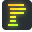

In [11]:
%%pyinstrument
import scipy.optimize
def f(x):
    cost, grad = f_batched(x[None])
    return cost[0], grad[0]

counter = 0

sol_to_solve = copy.deepcopy(sol)
sol_to_solve.select_ids([1]*1)

sol_tmp = copy.deepcopy(sol_to_solve)
sol_tmp.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.01,sol_tmp.xyt.shape))

x0 = cp.concatenate((sol_tmp.xyt.reshape(sol_tmp.N_solutions,-1), sol_tmp.h.reshape(sol_tmp.N_solutions,-1)),axis=1).get()

x0 = x0.ravel()

res = scipy.optimize.minimize(f, x0, method='L-BFGS-B', jac=True,
                                options={'maxiter': 1000, 'gtol':1e-3, 'norm':np.inf, 'xrtol': 0, 'disp': True, 'maxcor':10})

x_result = cp.array(res.x.reshape(1,-1))
sol_opt = copy.deepcopy(sol_to_solve)
NN = sol_opt.N_trees*3
sol_opt.xyt[...] = x_result[:,:NN].reshape(sol_opt.xyt.shape)
sol_opt.h[...] = x_result[:,NN:].reshape(sol_opt.h.shape)    
counter, cost.compute_cost_allocate(sol_opt)[0].get().item()
#res


In [13]:
import seis_numerics
import lbfgs_torch
import importlib
importlib.reload(lbfgs_torch)

sol_to_solve = copy.deepcopy(sol)
sol_to_solve.select_ids([1]*10)
sol_to_solve.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.01,sol_to_solve.xyt.shape))

#print(counter, cost.compute_cost_allocate(sol_to_solve)[0].get())

for ii in range(sol_to_solve.N_solutions):
    sol_tmp = copy.deepcopy(sol_to_solve)
    sol_tmp.select_ids([ii])

    #print(counter, cost.compute_cost_allocate(sol_tmp)[0].get().item())
    
    x0 = cp.concatenate((sol_tmp.xyt.reshape(sol_tmp.N_solutions,-1), sol_tmp.h.reshape(sol_tmp.N_solutions,-1)),axis=1)
    x0=x0.flatten()
    from torch.utils.dlpack import to_dlpack, from_dlpack
    x0 = from_dlpack(x0.toDlpack())

    counter = 0

    cost = pack_ga.GA().fine_relaxers[0].cost

    def f_torch(x):
        global counter
        counter += 1
        x=cp.from_dlpack(to_dlpack(x))
        global sol_tmp
        NN = sol_tmp.N_trees*3
        sol_tmp.xyt[...] = x[:NN].reshape(sol_tmp.xyt.shape)
        sol_tmp.h[...] = x[NN:].reshape(sol_tmp.h.shape)
        cost.compute_cost(sol_tmp, tmp_cost, tmp_grad, tmp_grad_h)
        res = cp.zeros_like(x)
        res[:NN] = tmp_grad.reshape(sol_tmp.N_solutions,-1)
        res[NN:] = tmp_grad_h.reshape(sol_tmp.N_solutions,-1)
        #print(tmp_cost)
        return from_dlpack(tmp_cost.toDlpack()), from_dlpack(res.toDlpack())

    f_torch(x0)

    res=lbfgs_torch.lbfgs(
        f_torch,x0,tolerance_grad=1e-3, tolerance_change=0, max_iter=100, history_size=10, line_search_fn='strong_wolfe'
    )
    x_result = cp.from_dlpack(to_dlpack(res))
    #print(x0[0].cpu().item(), x_result[0])

    sol_opt = copy.deepcopy(sol_tmp)
    NN = sol_opt.N_trees*3
    sol_opt.xyt[...] = x_result[:NN].reshape(sol_opt.xyt.shape)
    sol_opt.h[...] = x_result[NN:].reshape(sol_opt.h.shape)    
    print(counter, cost.compute_cost_allocate(sol_opt)[0].get().item())

/tmp/ipykernel_72768/1348321375.py:21: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/tmp/ipykernel_72768/1348321375.py:40: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost.toDlpack()), from_dlpack(res.toDlpack())


112 0.19435313487978248
112 0.1943546768799785
108 0.19435307197785007
111 0.19435329616643954
109 0.19435401237967487
113 0.1943531285459542
109 0.19435325471645126
110 0.19435375350313158
114 0.19435342322702104
108 0.1943551212145437


In [14]:
%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [ ]:
%%time
#%%pyinstrument
import lbfgs_torch_parallel
import importlib
import pack_ga
importlib.reload(lbfgs_torch_parallel)

sol_to_solve = copy.deepcopy(sol)
sol_to_solve.select_ids([1]*1000)
sol_to_solve.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.01,sol_to_solve.xyt.shape))

sol_tmp = copy.deepcopy(sol_to_solve)
    
x0 = cp.concatenate((sol_tmp.xyt.reshape(sol_tmp.N_solutions,-1), sol_tmp.h.reshape(sol_tmp.N_solutions,-1)),axis=1)
from torch.utils.dlpack import to_dlpack, from_dlpack
import numpy as np
x0 = from_dlpack(x0.toDlpack())

counter = 0
counter_n = 0

cost = pack_ga.GA().fine_relaxers[0].cost

def f_torch(x):
    global counter, counter_n
    counter += 1
    counter_n += x.shape[0]
    x=cp.from_dlpack(to_dlpack(x))
    global sol_tmp
    NN = sol_tmp.N_trees*3
    sol_tmp.xyt = cp.ascontiguousarray(x[:,:NN].reshape(x.shape[0],-1,3))
    sol_tmp.h = cp.ascontiguousarray(x[:,NN:].reshape(x.shape[0],-1))
    tmp_cost, tmp_grad, tmp_grad_h = cost.compute_cost_allocate(sol_tmp)
    #tmp_cost, tmp_grad, tmp_grad_h = cost.compute_cost_allocate(sol_tmp)
    res = cp.zeros_like(x)
    res[:,:NN] = tmp_grad.reshape(sol_tmp.N_solutions,-1)
    res[:,NN:] = tmp_grad_h.reshape(sol_tmp.N_solutions,-1)
    #print(tmp_cost)
    return from_dlpack(tmp_cost.toDlpack()), from_dlpack(res.toDlpack())

kgs.debugging_mode = 2
f_torch(x0)

kgs.profiling=False
res=lbfgs_torch_parallel.lbfgs(
    f_torch,x0,tolerance_grad=1e-3, tolerance_change=0, max_iter=100, history_size=10, line_search_fn='strong_wolfe'
)
x_result = cp.from_dlpack(to_dlpack(res))
#print(x0[0].cpu().item(), x_result[0])

sol_opt = copy.deepcopy(sol_to_solve)
NN = sol_opt.N_trees*3
sol_opt.xyt[...] = x_result[:,:NN].reshape(sol_opt.xyt.shape)
sol_opt.h[...] = x_result[:,NN:].reshape(sol_opt.h.shape)    
val = cost.compute_cost_allocate(sol_opt)[0].get()
val_np = np.asarray(val)
if val_np.size == 1:
    print(counter, f"{val_np.item():.18e}")
else:
    print(counter, counter_n/counter, np.array2string(val_np, precision=18, floatmode='unique'), np.array2string(np.mean(val_np), precision=18, floatmode='unique'))

<timed exec>:16: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
<timed exec>:38: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.


CPU times: user 12.5 s, sys: 66.7 ms, total: 12.6 s
Wall time: 12.6 s


KeyboardInterrupt: 

(22, array([0.22116002]))

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:17:56  Samples:  104
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.419     CPU time: 0.399
/   _/                      v5.1.1

Cell [190]

0.418 <module>  ../ipykernel_1002/2179167224.py:1
|- 0.397 lbfgs_minimize_batched_cupy_scipy  bfgs_cupy.py:7
|  |- 0.359 strong_wolfe_search  bfgs_cupy.py:134
|  |  |- 0.324 zoom  bfgs_cupy.py:184
|  |  |  |- 0.282 f_batched2  ../ipykernel_1002/2179167224.py:21
|  |  |  |  |- 0.259 Device.synchronize  <built-in>
|  |  |  |  `- 0.019 CostCompound.compute_cost  pack_cost.py:48
|  |  |  |     `- 0.018 CostCompound._compute_cost  pack_cost.py:86
|  |  |  |        |- 0.012 BoundaryDistanceCost.compute_cost  pack_cost.py:48
|  |  |  |        `- 0.006 [self]  pack_cost.py
|  |  |  |- 0.019 [self]  bfgs_cupy.py
|  |  |  |- 0.008 where  cupy/_sorting/search.py:177
|  |  |  |- 0.006 _cubic_minimizer  bfgs_cupy.py:119
|  |  |  `- 0.005 _safe_step  bfgs_cupy.py:127
|  |  `- 0.030 f_batched2  ../ipykernel_1002/2179167224.py:21
|  |     `- 0.028 Device.synchronize  <built-in>
|  |- 0.027 f_batched2  ../ipykernel_1002/2179167224.py:21
|  |  `- 0.026 Device.synchronize  <built-in>
|  `- 0.004 [self]  bfgs_cupy.py
`- 0.016 reload  importlib/__init__.py:94
   `- 0.011 open_code  <built-in>
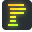

In [ ]:
%%pyinstrument
import bfgs_cupy
import importlib
importlib.reload(bfgs_cupy)

sol_to_solve = copy.deepcopy(sol)
sol_to_solve.select_ids([1]*1)

sol_tmp = copy.deepcopy(sol_to_solve)
sol_tmp.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.01,sol_tmp.xyt.shape))

x0 = cp.concatenate((sol_tmp.xyt.reshape(sol_tmp.N_solutions,-1), sol_tmp.h.reshape(sol_tmp.N_solutions,-1)),axis=1).get()

tmp_grad = cp.zeros_like(sol_tmp.xyt)
tmp_grad_h = cp.zeros_like(sol_tmp.h)
tmp_cost= cp.zeros(sol_tmp.N_solutions, dtype=kgs.dtype_cp)

counter = 0

cost = pack_ga.GA().fine_relaxers[0].cost

def f_batched2(x):
    global counter
    counter += 1
    global sol_tmp
    NN = sol_tmp.N_trees*3
    sol_tmp.xyt[...] = x[:,:NN].reshape(sol_tmp.xyt.shape)
    sol_tmp.h[...] = x[:,NN:].reshape(sol_tmp.h.shape)
    cost.compute_cost(sol_tmp, tmp_cost, tmp_grad, tmp_grad_h)
    res = cp.zeros_like(x)
    res[:,:NN] = tmp_grad.reshape(sol_tmp.xyt.shape[0],-1)
    res[:,NN:] = tmp_grad_h.reshape(sol_tmp.h.shape[0],-1)
    cp.cuda.Device().synchronize()
    #res[0,0].get().item()  # force synchronization for accurate profiling
    return tmp_cost, res

kgs.debugging_mode = 2

results = bfgs_cupy.lbfgs_minimize_batched_cupy_scipy(
    f=f_batched2,
    x0=x0,
    gtol=1e-3,
    max_iter=1000,
    maxcor = 10,
)

x_result = results['x']

sol_opt = copy.deepcopy(sol_to_solve)
NN = sol_opt.N_trees*3
sol_opt.xyt[...] = x_result[:,:NN].reshape(sol_opt.xyt.shape)
sol_opt.h[...] = x_result[:,NN:].reshape(sol_opt.h.shape)    
sol_opt.check_constraints()
counter, cost.compute_cost_allocate(sol_opt)[0].get()


In [ ]:
results

{'x': array([[-1.92794436, -1.36275579,  2.96267869, -1.92158589, -0.32045729,
          2.94215238, -1.92971313,  0.74729964,  2.95500617, -1.93952197,
          1.81066505,  2.9629521 , -1.66416679, -1.79059866, -0.18174341,
         -1.34028133, -1.34866844,  2.94558535, -1.65604259, -0.75096133,
         -0.18826713, -1.3384977 , -0.28872153,  2.95362888, -1.66911037,
          0.2974256 , -0.18109542, -1.32803397,  0.75458939,  2.95948239,
         -1.64341062,  1.3482918 , -0.19154093, -1.33982614,  1.80803087,
          2.9664639 , -1.06666344, -1.81027264, -0.19466332, -0.72587935,
         -1.3449234 ,  2.96060572, -1.07217907, -0.74814045, -0.18525165,
         -0.7301984 , -0.29223265,  2.95741013, -1.05873483,  0.30162273,
         -0.18352731, -0.7260724 ,  0.73589051,  2.95197747, -1.0702277 ,
          1.34596717, -0.18916993, -0.71743587,  1.79321276,  2.96485696,
         -0.48304954, -1.80521992, -0.18479098, -0.12721993, -1.34524368,
          2.96310765, -0.46970809